# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

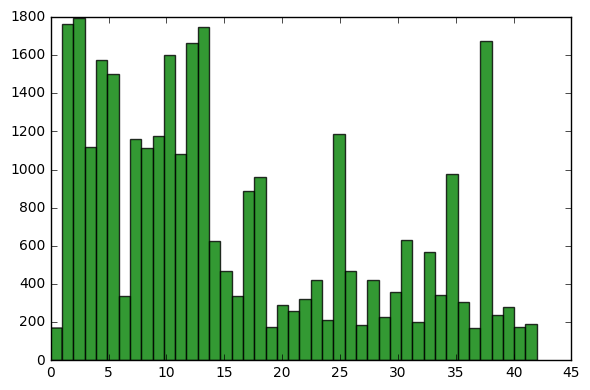

In [1]:
# Load pickled data
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

%matplotlib inline

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

idx_train = np.where(y_train < 500)
idx_test = np.where(y_test < 500)

X_train = X_train[idx_train]
X_test = X_test[idx_test]
y_train = y_train[idx_train]
y_test = y_test[idx_test]

X_train, y_train = shuffle(X_train, y_train)

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

plt.figure()
plt.hist(np.array(y_train), np.unique(y_train).shape[0], color='green', alpha=0.8)
plt.tight_layout()
plt.show()


Some classes have very few data, augment them by rotating them or doing some processing on the images

Number of training examples = 65818
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


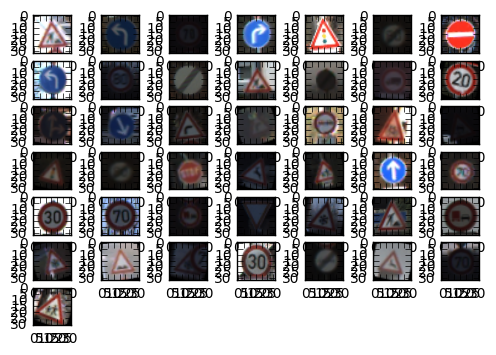

In [26]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:-1]

# TODO: how many classes are in the dataset
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# From the histogram above, a target of 1500 training samples for each class seems reasonable
min_samples_per_class = 1500

plt.figure()
for i in range(n_classes):
    plt.subplot(7, 7, i+1)
    plt.imshow(X_train[y_train[np.where(y_train == i)][0]])

## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

(31367,)
23


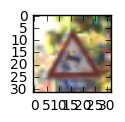

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
print(y_train.shape)
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

## Preprocess Data

Shuffle the training data.

Augment data by randomly apply rotation to datasets with few data

(65818, 32, 32, 3) (65818,)
(65818, 32, 32, 3) (65818,)


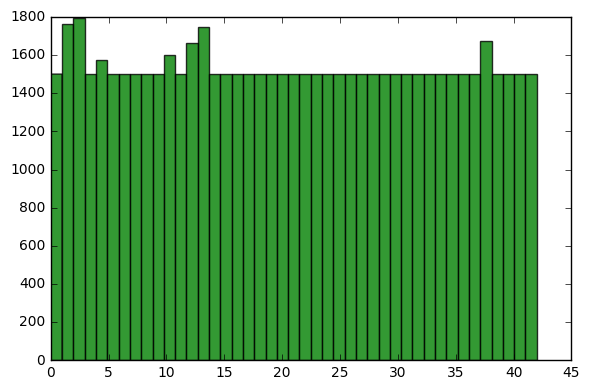

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import random
random.seed()
new_data_size = 0
for i in range(n_classes):
    n_samples_class = y_train[np.where(y_train == i)].shape[0]
    X_train_class = X_train[np.where(y_train == i)]
    #print("Class %s containts %s samples" % (i, n_samples_class))
    if n_samples_class < min_samples_per_class:
        #print("augmenting with %s virtual samples" % (min_samples_per_class - n_samples_class))
        new_data_size += min_samples_per_class - n_samples_class
        
new_data = np.zeros((new_data_size, 32, 32, 3), np.uint8)
new_label = np.zeros((new_data_size, ))

counter = 0
for i in range(n_classes):
    n_samples_class = y_train[np.where(y_train == i)].shape[0]
    X_train_class = X_train[np.where(y_train == i)]
    if n_samples_class < min_samples_per_class:
        for idx in range(min_samples_per_class - n_samples_class):
            # generate number index between 0 and n_samples_class
            rand_idx = random.randint(0, n_samples_class-1)
            rand_rot_angle = random.uniform(-20, 20)
            M = cv2.getRotationMatrix2D((image_shape[0]/2, image_shape[1]/2), rand_rot_angle, 1)
            dst = cv2.warpAffine(X_train_class[rand_idx, :, :, :] ,M ,image_shape)
            new_data[counter] = dst
            new_label[counter] = i
            counter += 1

print(X_train.shape, y_train.shape)
X_train = np.concatenate((X_train, new_data))
y_train = np.concatenate((y_train, np.array(new_label)))
print(X_train.shape, y_train.shape)

plt.hist(np.array(y_train), np.unique(y_train).shape[0], color='green', alpha=0.8)
plt.tight_layout()
plt.show()


## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [13]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

LeNet-5 Network
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.
### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [14]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    #  Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels
Train LeNet to classify traffic sign data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [15]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify the traffic signs

You do not need to modify this section.

In [16]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.



In [18]:

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver.save(sess, './lenet')
        print("Model saved")    
    except NameError:
        saver = tf.train.Saver()
        saver.save(sess, 'lenet_model')
        print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.775

EPOCH 2 ...
Validation Accuracy = 0.877

EPOCH 3 ...
Validation Accuracy = 0.915

EPOCH 4 ...
Validation Accuracy = 0.921

EPOCH 5 ...
Validation Accuracy = 0.933

EPOCH 6 ...
Validation Accuracy = 0.946

EPOCH 7 ...
Validation Accuracy = 0.954

EPOCH 8 ...
Validation Accuracy = 0.944

EPOCH 9 ...
Validation Accuracy = 0.963

EPOCH 10 ...
Validation Accuracy = 0.955

EPOCH 11 ...
Validation Accuracy = 0.957

EPOCH 12 ...
Validation Accuracy = 0.965

EPOCH 13 ...
Validation Accuracy = 0.957

EPOCH 14 ...
Validation Accuracy = 0.967

EPOCH 15 ...
Validation Accuracy = 0.956

EPOCH 16 ...
Validation Accuracy = 0.967

EPOCH 17 ...
Validation Accuracy = 0.971

EPOCH 18 ...
Validation Accuracy = 0.968

EPOCH 19 ...
Validation Accuracy = 0.962

EPOCH 20 ...
Validation Accuracy = 0.958

Model saved


## Evaluate the Model

In [19]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet_model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.888


##Now Test the classifier with images from internet

In [20]:
def predict(X_data):
    sess = tf.get_default_session()
    predic = tf.nn.softmax(logits)
    classification = sess.run(predic, feed_dict={x: X_data})
    return classification

In [36]:
import glob
new_signs = glob.glob("traffic_signs/*.png")

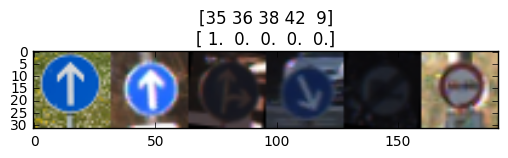

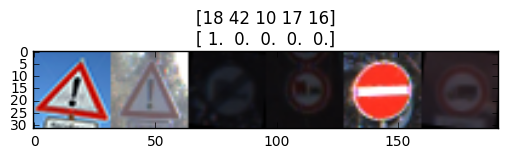

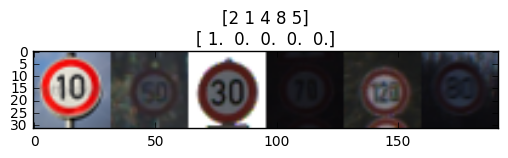

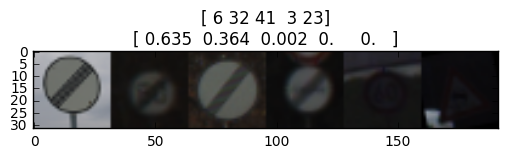

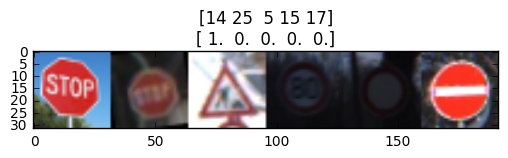

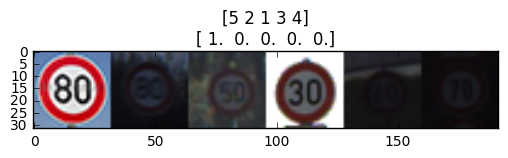

In [37]:
new_sign_images = []
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
#loader = tf.train.import_meta_graph('lenet.meta')
#loader.restore(sess, tf.train.latest_checkpoint('./'))
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet_model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    for sign in new_signs:
        sign_image = cv2.cvtColor(cv2.imread(sign), cv2.COLOR_BGR2RGB)
        sign_image = np.reshape(sign_image, (1, 32, 32, 3))
        prediction = predict(sign_image)[0, :]
        prediction_sorted = np.argsort(prediction)[::-1]
        plt.figure()
        plt.imshow(np.hstack((sign_image[0], 
                              X_train[y_train==prediction_sorted[0]][0],
                              X_train[y_train==prediction_sorted[1]][0],
                              X_train[y_train==prediction_sorted[2]][0],
                              X_train[y_train==prediction_sorted[3]][0],
                              X_train[y_train==prediction_sorted[4]][0])))
        plt.title(str(prediction_sorted[:5])+"\n"+str(prediction[prediction_sorted[:5]]))